# Modeling- Variable Selection
- Robert Shaw, Sean Coleman, Spencer Evans, Daniel Alpert
- CS109a Project- Data Driven March Madness

---

In this file, we perform variable selection for our logistic regression model of head to head games. To do this, we will use a combination of subset selection methods and regularization methods. Further, we will consider looking at scoring differential and using lasso regression as a variable selection method.


Further, we will also look at random forest, lda, and svc to see if there is a major improvement in our model's accuracy. However, we like the interpretaion available using logistic regression, so unless we see a major improvement in accuracy we will stick with logistic regession.

---

In [1]:
import march_madness_classes as mmc
import march_madness_games as mmg
import march_madness_models as mmm
import march_madness_train_and_tune as mmtt

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import Lasso as Lasso
from sklearn.ensemble import RandomForestClassifier as random_forest

---
### 1) Load Our Data

In [2]:
# read in the dataset
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")
games = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")

seeds_arr = mmg.filter_into_seasons(seeds)
slots_arr = mmg.filter_into_seasons(slots)
games_arr = mmg.filter_into_seasons(games)

In [3]:
# extract predictors
markov          = pd.read_csv("datasets/our_data/stationary", index_col=0)
rpi             = pd.read_csv("datasets/our_data/rpi", index_col=0)
weighted_wins   = pd.read_csv("datasets/our_data/weighted_wins", index_col=0)
consistency     = pd.read_csv("datasets/our_data/consistency", index_col=0)
dominance       = pd.read_csv("datasets/our_data/dominance", index_col=0)
bad_losses      = pd.read_csv("datasets/our_data/bad_losses", index_col=0)
tough_wins      = pd.read_csv("datasets/our_data/tough_wins", index_col=0)
close_wins      = pd.read_csv("datasets/our_data/close_wins",index_col=0)
close_wins_perc = pd.read_csv("datasets/our_data/close_wins_perc", index_col=0)
momentum        = pd.read_csv("datasets/our_data/momentum", index_col=0)
past_resul      = pd.read_csv("datasets/our_data/past_results", index_col=0)
def_eff         = pd.read_csv("datasets/our_data/def_eff", index_col=0)
off_eff         = pd.read_csv("datasets/our_data/off_eff", index_col=0)
tempo           = pd.read_csv("datasets/our_data/tempo", index_col=0)
win_ratio       = pd.read_csv("datasets/our_data/win_ratio", index_col=0)
wins            = pd.read_csv("datasets/our_data/team_summary_data/regular_season_wins", index_col=0)
losses          = pd.read_csv("datasets/our_data/team_summary_data/regular_season_loss_matrix", index_col=0)
luck            = pd.read_csv("datasets/our_data/luck", index_col=0)

# seeds
seed_matrix_df  = pd.read_csv("datasets/our_data/team_summary_data/seeds_matrix", index_col=0)

In [4]:
reload(mmg)

<module 'march_madness_games' from 'march_madness_games.pyc'>

In [5]:
# get data into correct format
predictor_names = ["min_index_id", 
                   "max_index_id", 
                   "markov",
                   "rpi",
                   "weighted_wins",
                   "consistency",
                   "dominance", 
                   "bad_losses", 
                   "tough_wins", 
                   "close_wins", 
                   "close_wins_perc", 
                   "momentum",
                   "past_resul",
                   "def_eff",
                   "off_eff",
                   "tempo",
                   "win ratio",
                   "wins",
                   "losses",
                   "luck"] 

# package the predictors into an array
predictor_dfs = [markov, 
                 rpi,
                 weighted_wins,  
                 consistency,
                 dominance, 
                 bad_losses, 
                 tough_wins, 
                 close_wins, 
                 close_wins_perc, 
                 momentum,
                 past_resul,
                 def_eff,
                 off_eff,
                 tempo,
                 win_ratio,
                 wins,
                 losses,
                 luck] 

In [6]:
pred, resp = mmg.generate_multiple_years_of_games(range(2003, 2016), 
                                                  seeds_arr, 
                                                  slots_arr, 
                                                  games_arr, 
                                                  predictor_names,
                                                  predictor_dfs,
                                                  scoring_dif = False)

In [7]:
pred.head()

,min_index_id,max_index_id,markov,rpi,weighted_wins,consistency,dominance,bad_losses,tough_wins,close_wins,close_wins_perc,momentum,past_resul,def_eff,off_eff,tempo,win ratio,wins,losses,luck
0,1328.0,1354.0,0.004267,0.147791,1.438690,-4.0,4.0,-8.0,3.0,1.0,0.166667,0.027911,4.0,-0.061449,0.098682,-242.600,0.312454,4.0,-4.0,3.687546
1,1190.0,1448.0,-0.003134,-0.099574,-0.922222,5.0,-7.0,8.0,-2.0,2.0,0.000000,-0.011056,-1.0,0.031186,-0.093820,67.550,-0.265337,-7.0,5.0,-6.734663
2,1264.0,1393.0,-0.001668,-0.060741,-1.209524,1.0,-1.0,4.0,-2.0,-1.0,-0.371429,-0.027433,-1.0,-0.024369,-0.040364,-27.200,-0.033941,-1.0,1.0,-0.966059
3,1122.0,1257.0,-0.003825,-0.074778,-1.672619,1.0,-4.0,4.0,0.0,4.0,0.317460,-0.005877,0.0,0.058379,-0.098145,-349.875,-0.303111,-4.0,1.0,-3.696889
4,1139.0,1280.0,-0.001750,-0.022623,-1.723077,-4.0,3.0,-2.0,-3.0,4.0,0.375000,-0.006086,0.0,0.109495,0.077419,-242.275,-0.058307,3.0,-4.0,3.058307


In [8]:
resp.head()

,min_index_win
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0


---

### 2) Train Test Split - Windowing Approach

For our train test splits, we will be using a "window" approach. For each year, we will build a model based on the previous 3 years. This will allow us to avoid issues about the idea that the games from year to year are a dependent time series, and will prevent us from over fitting to a specific year.

In [9]:
train_test_arr = []

window   = 3
min_year = 2006
max_year = 2014

year_range = range(min_year, max_year)

# generate our train test split for each year
for year in year_range:
    # do the split for the current year
    train_test_tuple = mmtt.train_test_split(window, 
                                             year, 
                                             seeds_arr, 
                                             slots_arr, 
                                             games_arr, 
                                             predictor_names, 
                                             predictor_dfs)
    
    # add to our array
    train_test_arr.append(train_test_tuple)

--- 

### 3) Variable Selection

We will try a few methods: 

- Forward Step Wise Subset Selection with Logistic Regression
- Random Forest
- Lasso Regression on the Scoring Difference

In [10]:
# runs logisitic model on each year
def run_logistic_model (train_test_arr, variables, c=1, max_year=2014, min_year=2006, print_res=True):
    # high regularization

    # buffer for scores
    scores = np.zeros(max_year - min_year)
    coef_arr = np.zeros((scores.shape[0], len(variables)))

    # iterate years
    for year in year_range:
        # get train data
        train_x = train_test_arr[year - min_year][0][variables]
        train_y = train_test_arr[year - min_year][1].values[:, 0]

        # get cross validation set
        cross_x = train_test_arr[year - min_year][2][variables]
        cross_y = train_test_arr[year - min_year][3].values[:, 0]

        # scaling
        scaler = StandardScaler().fit(train_x)
        scaled_train_x = scaler.transform(train_x)
        scaled_cross_x = scaler.transform(cross_x)

        # init model
        model = LogReg(C=c)

        # fit model
        model.fit(scaled_train_x, train_y)

        # get coefs
        coef_arr[year - min_year, :] = model.coef_[0]

        # score model
        scores[year - min_year] = model.score(scaled_cross_x, cross_y)

    # results 
    mean_coefs = np.average(coef_arr, axis=0)
    coef_series = pd.Series(mean_coefs, index=variables)

    if print_res:
        print "Average Beta:"
        print coef_series.sort_values(ascending=False)
    
    # return the average score
    return np.average(scores), coef_series

In [11]:
# runs logisitic model on each year
def run_random_forest_model (train_test_arr, variables, max_year=2014, min_year=2006):
    # high regularization
    c = 1

    # buffer for scores
    scores = np.zeros(max_year - min_year)
    coef_arr = np.zeros((scores.shape[0], len(variables)))

    # iterate years
    for year in year_range:
        # get train data
        train_x = train_test_arr[year - min_year][0][variables]
        train_y = train_test_arr[year - min_year][1].values[:, 0]

        # get cross validation set
        cross_x = train_test_arr[year - min_year][2][variables]
        cross_y = train_test_arr[year - min_year][3].values[:, 0]

        # scaling
        scaler = StandardScaler().fit(train_x)
        scaled_train_x = scaler.transform(train_x)
        scaled_cross_x = scaler.transform(cross_x)

        # init model
        model = random_forest(n_estimators = 100, max_depth=2)

        # fit model
        model.fit(scaled_train_x, train_y)

        # get coefs
        coef_arr[year - min_year, :] = model.feature_importances_

        # score model
        scores[year - min_year] = model.score(scaled_cross_x, cross_y)

    # results 
    mean_coefs = np.average(coef_arr, axis=0)
    coef_series = pd.Series(mean_coefs, index=variables)

    print "Average Beta:"
    print coef_series.sort_values(ascending=False)
    
    # return the average score
    return np.average(scores), coef_series

In [12]:
# runs logisitic model on each year
def run_lasso_model (train_test_arr, variables, alpha, max_year=2014, min_year=2006, print_res=True):
    # buffer for scores
    scores = np.zeros(max_year - min_year)
    coef_arr = np.zeros((scores.shape[0], len(variables)))

    # iterate years
    for year in year_range:
        # get train data
        train_x = train_test_arr[year - min_year][0][variables]
        train_y = train_test_arr[year - min_year][1].values[:, 0]

        # get cross validation set
        cross_x = train_test_arr[year - min_year][2][variables]
        cross_y = train_test_arr[year - min_year][3].values[:, 0]

        # scaling
        scaler = StandardScaler().fit(train_x)
        scaled_train_x = scaler.transform(train_x)
        scaled_cross_x = scaler.transform(cross_x)

        # init model
        model = Lasso(alpha=alpha)

        # fit model
        model.fit(scaled_train_x, train_y)

        # get coefs
        coef_arr[year - min_year, :] = model.coef_

        # score model
        scores[year - min_year] = model.score(scaled_cross_x, cross_y)

    # results 
    mean_coefs = np.average(coef_arr, axis=0)
    coef_series = pd.Series(mean_coefs, index=variables)

    if print_res:
        print "Average Beta:"
        print coef_series.sort_values(ascending=False)
    
    # return the average score
    return np.average(scores), coef_series

---
#### Backwards Stepwise Logistic

- Since all of our variables are standardized, we can compare the coefficients one-to-one in order to see which are more important. We will remove one at a time, picking the lowest abs(beta) in each step. Once we have tried models with all numbers of predictors (1 to 14), we will simply choose the model with the maximum cross validation score.

In [34]:
# list of the variables we care about
variables = predictor_names[2:]

# array of accuracies
accuracy_arr = np.zeros(len(variables))

# print with current set of variables
accuracy_arr[0], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[0])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov             0.835301
rpi                0.564075
momentum           0.295006
off_eff            0.160792
luck               0.068955
losses             0.068442
consistency        0.068442
dominance          0.067438
wins               0.067438
tough_wins         0.013625
win ratio          0.004624
close_wins_perc   -0.022888
close_wins        -0.100854
tempo             -0.117812
def_eff           -0.137567
past_resul        -0.178838
weighted_wins     -0.239996
bad_losses        -0.402662
dtype: float64

Avg Accuracy : 0.688492063492

Min Predictor: win ratio


Index([u'bad_losses', u'weighted_wins', u'past_resul', u'def_eff', u'tempo',
       u'close_wins', u'close_wins_perc', u'win ratio', u'tough_wins', u'wins',
       u'dominance', u'consistency', u'losses', u'luck', u'off_eff',
       u'momentum', u'rpi', u'markov'],
      dtype='object')


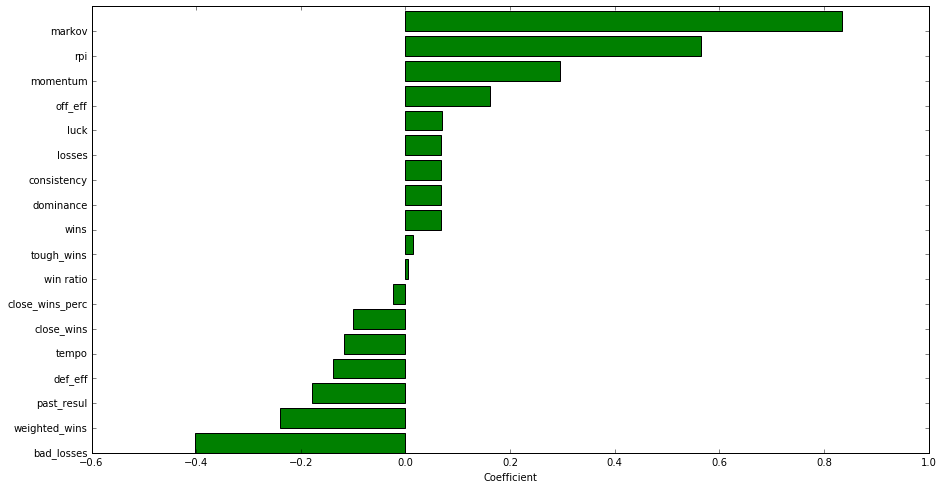

In [35]:
sorted_coef_series = coef_series.sort_values()
print sorted_coef_series.index

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

ax.barh(range(len(variables)), sorted_coef_series.values, color="g")
ax.set_xlabel("Coefficient")
plt.yticks(range(len(variables) + 1), tuple(sorted_coef_series.index.values))
ax.yaxis.labelpad = -10

As we can see here, 3 predictors, "markov", "rpi", and "bad_losses," are much more important than all of the others. However, we will see if there is some collinearity that leads to this by removing varibales one at a time.


Below, we iteratively remove the least important varibale until there is only one left. We will compare the scores of the models at the end.

In [36]:
variables.remove(min_abs_x)
i = 1

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov             0.836934
rpi                0.564859
momentum           0.294612
off_eff            0.167185
luck               0.067656
dominance          0.066964
wins               0.066964
losses             0.066830
consistency        0.066830
tough_wins         0.009523
close_wins_perc   -0.023386
close_wins        -0.100343
tempo             -0.115292
def_eff           -0.139813
past_resul        -0.175708
weighted_wins     -0.239589
bad_losses        -0.402061
dtype: float64

Avg Accuracy : 0.690476190476

Min Predictor: tough_wins


In [37]:
variables.remove(min_abs_x)
i = 2

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov             0.811013
rpi                0.567666
momentum           0.287956
off_eff            0.148186
luck               0.072703
wins               0.072658
dominance          0.072658
losses             0.065790
consistency        0.065790
close_wins_perc   -0.009305
close_wins        -0.111646
def_eff           -0.123289
tempo             -0.124044
past_resul        -0.154570
weighted_wins     -0.219354
bad_losses        -0.393630
dtype: float64

Avg Accuracy : 0.698412698413

Min Predictor: close_wins_perc


In [38]:
variables.remove(min_abs_x)
i = 3

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.746489
rpi              0.569686
momentum         0.311733
off_eff          0.147271
wins             0.080103
dominance        0.080103
losses           0.077506
consistency      0.077506
luck             0.077165
past_resul      -0.126679
close_wins      -0.126821
def_eff         -0.129177
tempo           -0.136741
weighted_wins   -0.215174
bad_losses      -0.392537
dtype: float64

Avg Accuracy : 0.702380952381

Min Predictor: luck


In [39]:
variables.remove(min_abs_x)
i = 4

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.747012
rpi              0.570645
momentum         0.313457
off_eff          0.147865
wins             0.110353
dominance        0.110353
losses           0.071717
consistency      0.071717
close_wins      -0.124954
past_resul      -0.127171
def_eff         -0.130495
tempo           -0.133471
weighted_wins   -0.216190
bad_losses      -0.392366
dtype: float64

Avg Accuracy : 0.700396825397

Min Predictor: consistency


In [40]:
variables.remove(min_abs_x)
i = 5

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.750641
rpi              0.568232
momentum         0.313453
off_eff          0.144412
losses           0.127200
wins             0.103947
dominance        0.103947
close_wins      -0.124893
past_resul      -0.127338
def_eff         -0.127924
tempo           -0.129393
weighted_wins   -0.215402
bad_losses      -0.390121
dtype: float64

Avg Accuracy : 0.700396825397

Min Predictor: dominance


In [41]:
variables.remove(min_abs_x)
i = 6

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.751498
rpi              0.570891
momentum         0.316712
wins             0.171414
off_eff          0.148745
losses           0.105170
close_wins      -0.121336
tempo           -0.123129
past_resul      -0.128408
def_eff         -0.133399
weighted_wins   -0.217460
bad_losses      -0.390213
dtype: float64

Avg Accuracy : 0.708333333333

Min Predictor: losses


In [42]:
variables.remove(min_abs_x)
i = 7

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.775962
rpi              0.556440
momentum         0.316272
off_eff          0.123989
wins             0.094678
tempo           -0.096500
def_eff         -0.115350
close_wins      -0.122114
past_resul      -0.128763
weighted_wins   -0.212245
bad_losses      -0.373213
dtype: float64

Avg Accuracy : 0.710317460317

Min Predictor: wins


In [43]:
variables.remove(min_abs_x)
i = 8

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.731109
rpi              0.623834
momentum         0.319433
off_eff          0.179899
tempo           -0.089422
close_wins      -0.099887
past_resul      -0.126730
def_eff         -0.174728
weighted_wins   -0.220403
bad_losses      -0.357551
dtype: float64

Avg Accuracy : 0.71626984127

Min Predictor: tempo


In [44]:
variables.remove(min_abs_x)
i = 9

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.663088
rpi              0.618914
momentum         0.298188
off_eff          0.188059
close_wins      -0.102235
past_resul      -0.124982
def_eff         -0.187764
weighted_wins   -0.213885
bad_losses      -0.373071
dtype: float64

Avg Accuracy : 0.708333333333

Min Predictor: close_wins


In [45]:
variables.remove(min_abs_x)
i = 10

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.705238
rpi              0.596071
momentum         0.250743
off_eff          0.217637
past_resul      -0.115820
weighted_wins   -0.209006
def_eff         -0.211680
bad_losses      -0.347275
dtype: float64

Avg Accuracy : 0.698412698413

Min Predictor: past_resul


In [46]:
variables.remove(min_abs_x)
i = 11

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.685882
rpi              0.539828
momentum         0.243739
off_eff          0.212124
def_eff         -0.212024
weighted_wins   -0.214893
bad_losses      -0.312466
dtype: float64

Avg Accuracy : 0.690476190476

Min Predictor: def_eff


In [47]:
variables.remove(min_abs_x)
i = 12

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.918705
rpi              0.496722
momentum         0.237007
off_eff          0.076667
weighted_wins   -0.268042
bad_losses      -0.349951
dtype: float64

Avg Accuracy : 0.690476190476

Min Predictor: off_eff


In [48]:
variables.remove(min_abs_x)
i = 13

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           0.960648
rpi              0.474713
momentum         0.219379
weighted_wins   -0.248433
bad_losses      -0.367529
dtype: float64

Avg Accuracy : 0.698412698413

Min Predictor: momentum


In [49]:
variables.remove(min_abs_x)
i = 14

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov           1.062516
rpi              0.532616
weighted_wins   -0.210669
bad_losses      -0.332528
dtype: float64

Avg Accuracy : 0.708333333333

Min Predictor: weighted_wins


In [50]:
variables.remove(min_abs_x)
i = 15

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov        0.982989
rpi           0.391584
bad_losses   -0.359787
dtype: float64

Avg Accuracy : 0.714285714286

Min Predictor: bad_losses


In [51]:
variables.remove(min_abs_x)
i = 16

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov    1.046127
rpi       0.608434
dtype: float64

Avg Accuracy : 0.708333333333

Min Predictor: rpi


In [53]:
variables.remove(min_abs_x)
i = 17

# print with current set of variables
accuracy_arr[i], coef_series = run_logistic_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_arr[i])
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov    1.526167
dtype: float64

Avg Accuracy : 0.710317460317

Min Predictor: markov


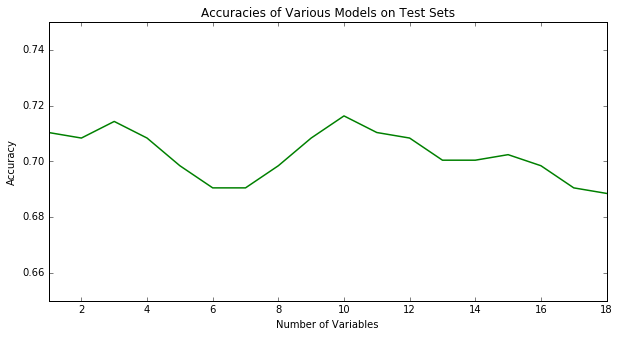

In [54]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(range(1, 19), accuracy_arr[::-1], color="g", label="logistic with step wise var selection", lw=1.5)
ax.set_xlim([1,18])
ax.set_ylim([.65,.75])
ax.set_xlabel("Number of Variables")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracies of Various Models on Test Sets")

We see a maximum when there is 10 variables, but this is essentially the same as having only 3 variables in our model. As such, we will use the model that has 3 variables, which are markov, rpi, and bad losses.

---
#### Random Forest 

In [58]:
# list of the variables we care about
variables = predictor_names[2:]

# print with current set of variables
accuracy_rf, importances_series = run_random_forest_model(train_test_arr, variables)

# minimum absolute value beta
min_abs_x = importances_series.abs().sort_values().index[0]

print "\nAvg Accuracy : {}".format(accuracy_rf)
print "\nMin Predictor: {}".format(min_abs_x)

Average Beta:
markov             0.183842
rpi                0.175608
win ratio          0.110519
momentum           0.096594
bad_losses         0.075417
luck               0.060572
weighted_wins      0.053741
off_eff            0.040263
wins               0.037476
dominance          0.035229
tough_wins         0.025649
losses             0.022621
past_resul         0.022155
consistency        0.021788
def_eff            0.015320
tempo              0.014417
close_wins         0.004615
close_wins_perc    0.004174
dtype: float64

Avg Accuracy : 0.69246031746

Min Predictor: close_wins_perc


AS we can see, Random Forest does not do quite as well as our logistic regression model, so we will not proceed to use Random Forest, since we prefer the interpretation of the Logistic Model.

---

#### Lasso

We like how lasso regression performs variable selection by pushing the coefficients of unimportant variables to 0. As such, we will fit a lasso model on the scoring difference of the two teams, which is a continous response, to get the important variables. Then, using the subset of varibales selected by the lasso, we will a logistic model.

In [59]:
train_test_arr_score_x = []

window   = 3
min_year = 2006
max_year = 2014

year_range = range(min_year, max_year)

# generate our train test split for each year
for year in year_range:
    # do the split for the current year, using the scoring difference
    train_test_tuple = mmtt.train_test_split(window, 
                                             year, 
                                             seeds_arr, 
                                             slots_arr, 
                                             games_arr, 
                                             predictor_names, 
                                             predictor_dfs,
                                             scoring_dif=True)
    
    # add to our array
    train_test_arr_score_x.append(train_test_tuple)

In [61]:
# cross validate the lambda
alpha_arr = range(-7, 8)
r2_scores = np.zeros(len(alpha_arr))

i = 0
for alpha in alpha_arr:
    # un lasso, get r2
    r2_scores[i], x = run_lasso_model(train_test_arr_score_x, variables, 10**alpha, print_res=False)
    
    i = i + 1

max_score = r2_scores.max()
max_index = r2_scores.argmax()

print "Max r2 of {} with Alpha = {}".format(max_score, 10**range(-7,8)[max_index])

Max r2 of 0.383706635824 with Alpha = 1


In [62]:
# list of the variables we care about
variables = predictor_names[2:]

# print with current set of variables
r2_lasso, importances_series = run_lasso_model(train_test_arr_score_x, variables, 1, print_res=True)

# minimum absolute value beta
min_abs_x = coef_series.abs().sort_values().index[0]

print "\nAvg R2 : {}".format(r2_lasso)

Average Beta:
rpi                3.547760
markov             3.275812
win ratio          0.946130
momentum           0.532639
past_resul         0.111317
dominance          0.070944
off_eff            0.039211
close_wins         0.000000
weighted_wins      0.000000
tough_wins         0.000000
luck               0.000000
losses             0.000000
def_eff            0.000000
tempo              0.000000
wins               0.000000
close_wins_perc    0.000000
consistency       -0.100189
bad_losses        -0.543115
dtype: float64

Avg R2 : 0.383706635824


Lasso Regression identifies the important variables for predicting the score of the games. We fit a logistic model on these variables (with nonzero coefficients) and compare it to our other models.

In [63]:
variables = ["rpi", "markov", "win ratio", "momentum", "past_resul", "dominance", "off_eff", "consistency", "bad_losses"]

In [64]:
# print with current set of variables
accuracy_log_reg_lasso_vars, coef_series = run_logistic_model(train_test_arr, variables)

print "\nAvg Accuracy : {}".format(accuracy_arr[i])

Average Beta:
markov         0.636353
rpi            0.435175
win ratio      0.335957
momentum       0.216902
dominance      0.050811
off_eff        0.043199
consistency    0.035364
past_resul    -0.125404
bad_losses    -0.360872
dtype: float64

Avg Accuracy : 0.714285714286


This does about the same as our logistic model with only 3 variables. Thus, we will just use the 3 variables, since adding more does not seem to increase our accuracy.

---

#### Visualize the Results

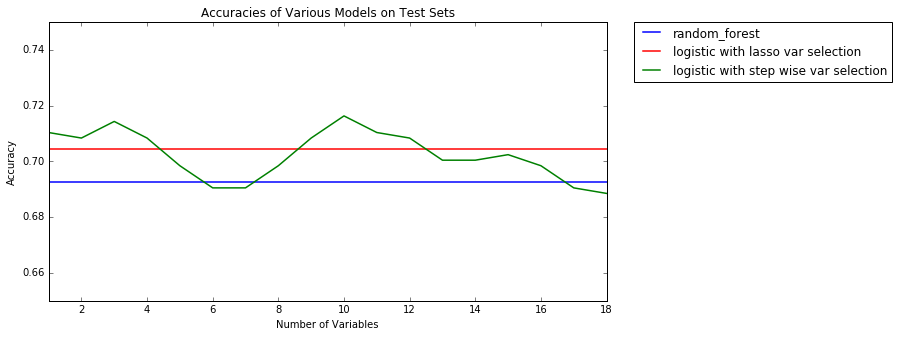

In [65]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot([0, 18], [accuracy_rf, accuracy_rf], color="b", label="random_forest", lw=1.5)
ax.plot([0, 18], [accuracy_log_reg_lasso_vars, accuracy_log_reg_lasso_vars], color="r", label="logistic with lasso var selection", lw=1.5)
ax.plot(range(1, 19), accuracy_arr[::-1], color="g", label="logistic with step wise var selection", lw=1.5)
ax.set_xlim([1,18])
ax.set_ylim([.65,.75])
ax.set_xlabel("Number of Variables")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracies of Various Models on Test Sets")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As we can see, our best model is using logistic regression with just the 3 variables.

---

### 4) Cross Validate Regularization Parameter

In [66]:
# cross validate for all 3 logistic models 
c_values = [.0001, .001, .01, .1, 1, 10, 100, 1000, 100000]
scores_10_var = np.zeros(len(c_values))
scores_3_var = np.zeros(len(c_values))
scores_lasso_vars = np.zeros(len(c_values))

In [67]:
# variables
variables_3 = ["markov", "rpi", "bad_losses"]
variables_10 = ["markov", "rpi", "momentum", "off_eff", "tempo", "close_wins", "past_resul", "def_eff", "weighted_wins","bad_losses"]
variables_lasso = ["rpi", "markov", "win ratio", "momentum", "past_resul", "dominance", "off_eff", "consistency", "bad_losses"]

In [68]:
# cross validate function
def cv_c_value(train_test_arr, variables, c_values):
    scores = np.zeros(len(c_values))
    
    i = 0
    for c_val in c_values:
        # print with current set of variables
        scores[i], x = run_logistic_model(train_test_arr, variables, c=c_val, print_res=False)
        
        i = i + 1 
        
    max_score = scores.max()
    max_score_ind = scores.argmax()
    
    print "Max Accuracy of {} with C = {}".format(max_score, c_values[max_score_ind])
    
    return scores

In [69]:
# cv for 3 variables
scores_3 = cv_c_value(train_test_arr, variables_3, c_values)

Max Accuracy of 0.718253968254 with C = 0.0001


In [70]:
# cv for 10 variables
scores_10 = cv_c_value(train_test_arr, variables_10, c_values)

Max Accuracy of 0.71626984127 with C = 1


In [71]:
# cv for lasso variables
scores_lasso = cv_c_value(train_test_arr, variables_lasso, c_values)

Max Accuracy of 0.706349206349 with C = 0.1


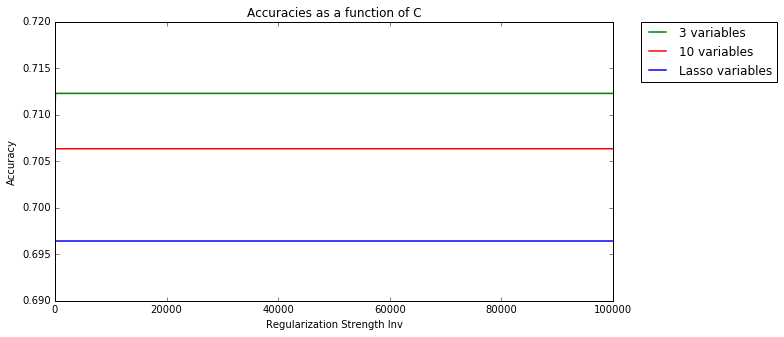

In [72]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(c_values, scores_3, label="3 variables", color="g", lw=1.5)
ax.plot(c_values, scores_10, label="10 variables", color="r", lw=1.5)
ax.plot(c_values, scores_lasso, label="Lasso variables", color="b", lw=1.5)
ax.set_ylim([.69,.72])
ax.set_xlabel("Regularization Strength Inv")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracies as a function of C")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As such, we will use the 3 variable model with C=1. The regularization is not important here, because we did the manual variable selection, so we already know that all of our variables are important.